# Transient

#### Dimensions:
50 by 50 by 1
dx = dy = 10 m
dz = 50 m
the model is unconfined

#### Subsurface Properties:
Heterogeneous
K = 1.0 m/day in x, y and z


3 LAYERS 
- TOP: 20M UNCONFINED SAND
- MIDDLE 10M CONFINED SILT
- BOTTOM UNCONFINED SAND

- poron1 = 0.35
- poron2 = 0.12
- poron3 = 0.35

Specific yield = 0.3
Storage coefficient=0.001

#### Boundary Conditions:
Right boundary is a constant head of 40 m relative to the datum, which is located at the bottom of the domain.
Left boundary is a constant head of 50 m relative to the datum, which is located at the bottom of the domain.
Recharge occurs at a rate of 1E-4 m/d uniformly across the domain
There is no ET in the domain


#### Initial Conditions:
Set the initial head to 50 everywhere, which will be replaced by the initial steady state solution
#### Pumping
Well located at row, column 20,20
Run your equivalent steady state model (annualized pumping rate) model. Use particles to track the time capture zone for the well after 25, 50, 75, 100 years of pumping. Bonus, see if you can use color to show captured particles!

### The Challenges
a) How does the capture zone evolve in time? Where does the early time capture zone get its water?

b) Where does the 'infinite time' capture zone get its water?

c) How does the extent of the capture zone change when layers are considered? Can you still define a 2D capture zone??

d) How does the extent of the 'infinite time' capture zone change when layers are added? Explain any difference in the lateral extent of the capture zone along the left boundary.

Add Particle tracking to the code
- show the time capture after 25, 50, 75, 100 years pumping
- show the infinite time capture zone
- use forward particles starting at the left boundary USE COLOR



### 1. Setup the environment

In [1]:
#import the basics
import flopy
import numpy as np
import matplotlib as mp
import os
import pandas as pd

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline

### 2. Create the model object

In [2]:
modelname = "Transient"
moddir=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\Course_Materials\Assignments\mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

In [3]:
modelname2 = "Transient_test"
moddir=r"C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\Course_Materials\Assignments\mf2005"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

In [4]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch','evt']
    for ext in file_extensions:
        os.remove(modelname + ext)
        os.remove(modelname2 + ext)

### 3. Setup the discretization (DIS package)
For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html

##### 3.1 Spatial discretization

In [5]:

nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 10 #width of grid cells in x direction 
dy= 10 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 50.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))   # used for plotting

##### 3.2 Temporal discretization

In [6]:
nper = 1 #number of stress periods 
nper0 = 0
steady = [True] #list noting the stress period type


sp_peryr = 2                            # periods for seasonality (two stress periods per year)
sp1_len = 90                            # Length of stress period 1 in days
sp2_len = 360-sp1_len                   # Length of stress period 2 in days
sim_years = 100                         # number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1)      # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True                 # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

nstp=perlen/30       # set monthly time steps per stress period to get monthly results
nstp[0]=1            #for the steady state solution we just want one output
nstp = nstp.astype(int)

elyears = (np.cumsum(perlen)-perlen[0])/360

##### 3.3 Create DIS object

In [7]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

In [8]:
dis2 = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

##### 3.4 Plot the grid
For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

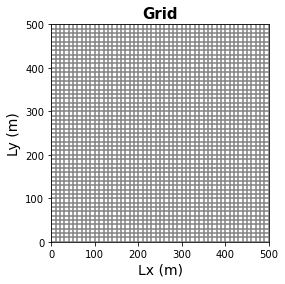

In [9]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()


### 4. Setup constant head boundaries, active cells and initial heads (BAS Package)
For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

##### 4.1 Define cell activity: IBOUND

In [10]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     
ibound2 = np.ones((nlay, nrow, ncol), dtype=np.int32)

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head

##### 4.2 Define starting head

In [11]:
#setup initial heads as 70 everywhere, this value will be preserved on constant head boundaries  
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = 50    # set all values to uniform initial condition
H_init[:, :, -1] = 30    #replace last (left) col with desired head value

##### 4.3 Create BAS object

In [12]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)
bas2 = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

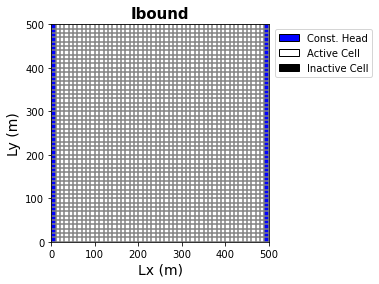

In [13]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)


# I'm not sure why this stopped working!  Can someone figure out why the right boundary doesn't show up as constant head??

### 5. Setup Layer Properties (LPF Package)
For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

##### 5.1 Set layer properties

In [14]:
K_horiz = .1    #horizontal hydraulic conductivity 
K_vert = .1     #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.03       #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

##### 5.2 Make LPF object

In [15]:

# kept in case you want to use it later

#assigns horizontal and vertical Ks and saves cell-by-cell budget data
# lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                                vka=K_vert, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53)

### 5b. Setup Cell-byCell Properties (BCF Package)
For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

##### 5b.1 Set cell properties and show K in top layer

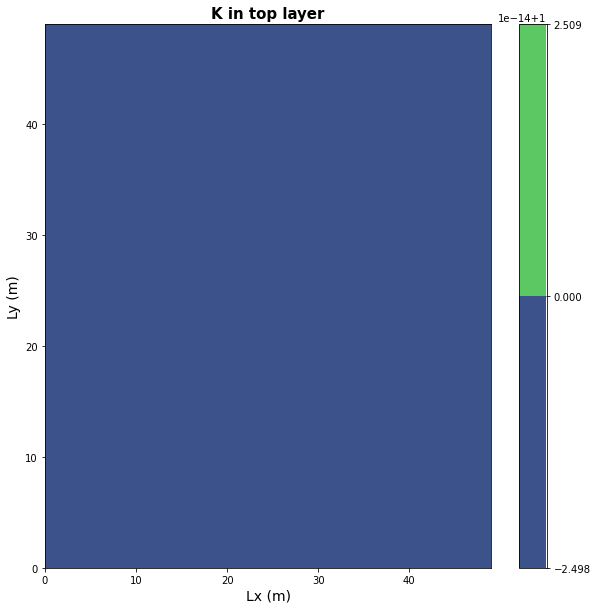

In [16]:
K_vals = np.zeros((ncol,nrow,nlay))
K_vals[:,:,:] = 1             # homoogeneous background hydraulic conductivity 
#K_vals[10:15,10:15,:] = 0.1   # low K inclusion

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.contourf(K_vals[:,:,0])
plt.colorbar()
plt.show()

##### 5b.2 Make BCF object

In [17]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None)
bcf2 = flopy.modflow.ModflowBcf(m2, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None)

### 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

##### 6.1 Setup outputs

In [18]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper):  
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']

##### 6.2 Make OC object

In [19]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)
oc2 = flopy.modflow.ModflowOc(model=m2, stress_period_data=oc_spd, compact=True)

### 7. Set the numerical solver (PCG Package)
We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

##### 7.1 Make the PCG object

In [20]:
pcg = flopy.modflow.ModflowPcg(model=m)
pcg2 = flopy.modflow.ModflowPcg(model=m2)

### 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

##### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [21]:
#Setup alternating pumping values
well_loc = [0, 20, 20]
Q1 = 0
Q2 = -500
Q_val=np.tile([Q2, Q1],sim_years)
Q_val=np.append(0,Q_val) # add a period of length 10 at the start for the steady state simulation
                      
Q = {}
for p in range(0,nper):    #loop over stress periods
    Q[p]=Q_val[p]

well_spd = {}                                                                  # create empty dictionary for well info
for per in range(nper):                                                        # transient models, iterate over stress periods to assign well stresses
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q_val[per]]]      # assign well coord & pump rate for each stress period
    
    
Q3 = -225
#Q3_val=np.tile(Q3,sim_years)
                        #total flow crossing right boundary (m3/day)
'''fluxes = [0,20,20,Q3]

sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period
'''

Q3_val=np.tile(Q3,sim_years)
Q3_val=np.append(0,Q3_val) # add a period of length 10 at the start for the steady state simulation
                      
Q3 = {}
for p in range(0,1):    #loop over stress periods
    Q3[p]=Q3_val[p]

well_spd2 = {}                                                                  # create empty dictionary for well info
for per in range(0,1):                                                        # transient models, iterate over stress periods to assign well stresses
    well_spd2[per] = [[well_loc[0], well_loc[1], well_loc[2], Q3_val[per]]]   

##### 8.2 Make the WEL object

In [22]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package
wel2 = flopy.modflow.mfwel.ModflowWel(m2, stress_period_data=well_spd2)

### 9. Add recharge (RCH Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfrch.html

##### 9.1 Setup recharge value

In [23]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol) - backgroun ET is zero everywhere
recharge = 5e-4 #m/day                          
#rech_zone[10:20,10:20] = recharge


rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object
rch2 = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)     #create rch object

#####  9.2 Add evapotranspiration

In [24]:
'''# ET - this is set up to show how you would add time-varying recharge in a localized area
ET_val1 = 0 #m/day
ET_val2 = 0.01 #m/day
ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
extinction_depth = 50

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone

#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    ET[p]=ET_zone*ET_val[p]

evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)'''

'# ET - this is set up to show how you would add time-varying recharge in a localized area\nET_val1 = 0 #m/day\nET_val2 = 0.01 #m/day\nET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate\nextinction_depth = 50\n\nET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows\nET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows\nET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))\nET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid\nET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone\n\n#Setup alternating ET values\nET_val=np.tile([ET_val1, ET_val2],sim_years)\nET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation\n                      \nET = {}\nfor p in range(0,nper):    #loop over

### 10. Write inputs and run the model
##### 10.1 Write Inputs

In [25]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder
        
m2.write_input()

##### 10.2 Run the model

In [26]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\Course_Materials\Assignments\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: Transient.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/19 12:45:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Wate

In [27]:
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\Course_Materials\Assignments\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: Transient_test.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/19 12:45:04

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground

### 11. Plot the results
#### 11.1 Read in the model outputs
For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html

For information on flow budget files see: http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

In [28]:
''''budgobj = bf.CellBudgetFile(modelname+'.cbc')
rec_list = budgobj.list_records() 

budgobj2 = bf.CellBudgetFile(modelname2+'.cbc')
rec_list2 = budgobj2.list_records() '''

"'budgobj = bf.CellBudgetFile(modelname+'.cbc')\nrec_list = budgobj.list_records() \n\nbudgobj2 = bf.CellBudgetFile(modelname2+'.cbc')\nrec_list2 = budgobj2.list_records() "

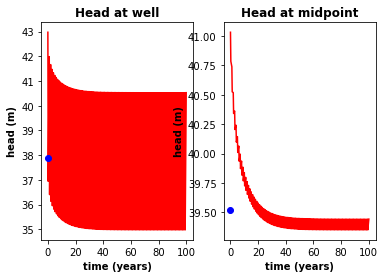

In [29]:
# Read the heads 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data

hds_yr = bf.HeadFile(modelname2+'.hds')                   # reads the binary head file
time_yr = hds_yr.get_times()                              # returns a list of timesteps
head2 = hds_yr.get_data()

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object


head2 = {}
headobjs = flopy.utils.binaryfile.HeadFile(modelname2+'.hds')

#get data from python objects
#head2 = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))
rowcounter=-1
for i in times:
    rowcounter+=1
    temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
    headarray[rowcounter,:,:] = temphead
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
    # print(tempfrf)
    frf[rowcounter,:,:] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
    fff[rowcounter,:,:] = tempfff

headarray2=np.zeros((len(time_yr),ncol,nrow))
rowcounters=-1
for i in time_yr:
    rowcounters+=1
    temphead2 = headobjs.get_data(totim=i) #append heads to head list for each stress per
    headarray2[rowcounters,:,:] = temphead2
    
# extract and plot head time series at specific points
time_series1 = headarray[:,domain_centerpt[1],domain_centerpt[2]]
time_series2 = headarray[:,well_loc[1],well_loc[2]]

time_series_1 = headarray2[:,domain_centerpt[1],domain_centerpt[2]]
time_series_2 = headarray2[:,well_loc[1],well_loc[2]]


plt.subplot(1,2,1)
plt.title("Head at well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.xticks([0,20,40,60,80,100], ['0', '20', '40','60','80','100'])
plt.plot(elyears, time_series2, 'r-') #plot the time series with points at each record
plt.rcParams["figure.figsize"] = (13,4)
plt.plot(time_series2.mean(), 'bo')

plt.subplot(1, 2, 2)
plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.xticks([0,20,40,60,80,100], ['0', '20', '40','60','80','100'])
plt.plot(elyears, time_series1, 'r-') #plot the time series with points at each record
plt.plot(time_series1.mean(), 'bo')
#plt.tight_layout()

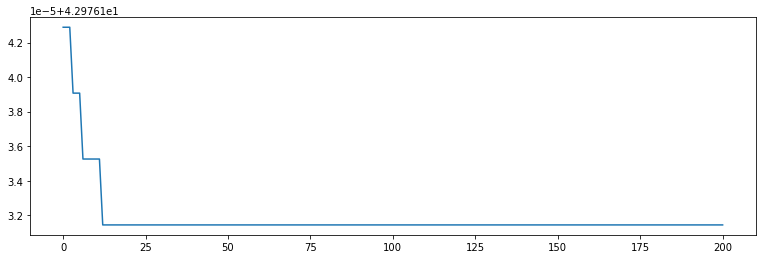

In [30]:
#print(len(headarray2))


plt.plot(time_series_2)  #,marker='o', color='mediumvioletred', markersize=4, linestyle='--')

In [31]:
'''def window(size):
    return np.ones(size)/float(size)

plt.plot(elyears,time_series1,'k.')
plt.plot(elyears[39:60],np.convolve(time_series1[39:60],window(2),'same'),'r')
#plt.plot(elyears,np.convolve(times,window(100),'same'),'b')
#plt.xticks([40,60], ['40','60'])'''

"def window(size):\n    return np.ones(size)/float(size)\n\nplt.plot(elyears,time_series1,'k.')\nplt.plot(elyears[39:60],np.convolve(time_series1[39:60],window(2),'same'),'r')\n#plt.plot(elyears,np.convolve(times,window(100),'same'),'b')\n#plt.xticks([40,60], ['40','60'])"

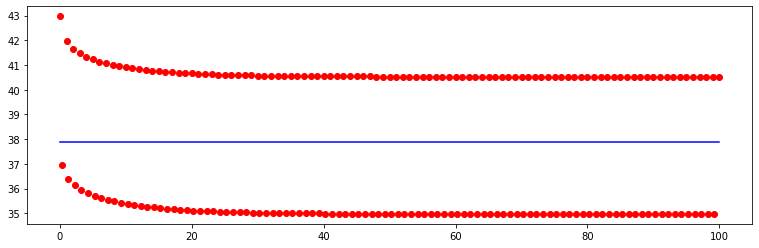

In [32]:
tstarr = []
for i in range(201):
    x = time_series2.mean()
    tstarr.append(x)

plt.plot(elyears, time_series2, 'ro') #plot the time series with points at each record
plt.plot(elyears, tstarr, 'b-')

In [33]:
# find the average at midpoint
testavg = []
x=[]
for i in range(200):
    x = ((time_series1[i+1]-time_series1[i])/2)+38.528
    testavg.append(x)
#print(testavg)

x1 = np.append(40,testavg)

''''plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.xticks([0,20,40,60,80,100], ['0', '20', '40','60','80','100'])
plt.plot(elyears, time_series1, 'r-')
plt.plot(elyears, x1)'''

'\'plt.title("Head at midpoint",fontweight=\'bold\')\nplt.xlabel(\'time (years)\',fontweight=\'bold\')\nplt.ylabel(\'head (m)\',fontweight=\'bold\')\nplt.xticks([0,20,40,60,80,100], [\'0\', \'20\', \'40\',\'60\',\'80\',\'100\'])\nplt.plot(elyears, time_series1, \'r-\')\nplt.plot(elyears, x1)'

In [34]:
tst=[]
for i in range(200):
    result = np.mean(time_series1.reshape(-1, 3), axis=1)
    #tst.append(result)
    
print(result)

[40.85213979 40.46162033 40.26887639 40.0832456  39.99766668 39.87417857
 39.82941437 39.73555628 39.71344884 39.6378212  39.63059362 39.56744258
 39.57066091 39.51639938 39.52711995 39.47927984 39.49544398 39.45226669
 39.47238413 39.43260066 39.4555982  39.41828283 39.44337463 39.40785726
 39.43447622 39.40026855 39.42799632 39.39473979 39.42328008 39.39071655
 39.41984431 39.38778814 39.41734187 39.38565445 39.41552226 39.38410187
 39.41419601 39.38297145 39.41323217 39.38214874 39.41252899 39.38154856
 39.41201782 39.38111369 39.41164398 39.38079453 39.41137314 39.3805631
 39.41117605 39.38039525 39.41103236 39.38027191 39.41092809 39.3801829
 39.4108518  39.38011805 39.41079458 39.380071   39.41075516 39.38003667
 39.41072591 39.38001124 39.41070429 39.37999344 39.41068904 39.37997945
 39.41067759]


In [35]:
for i in range(nrow):
    hgrad =(headarray[0,25,i]-headarray[0,25,-1])/Lx
    print("Head Gradient", hgrad, "m/m")
    


Head Gradient 0.04 m/m
Head Gradient 0.039344802856445316 m/m
Head Gradient 0.03868525695800781 m/m
Head Gradient 0.038021278381347653 m/m
Head Gradient 0.03735276794433594 m/m
Head Gradient 0.03667962646484375 m/m
Head Gradient 0.03600177764892578 m/m
Head Gradient 0.03531909942626953 m/m
Head Gradient 0.03463150024414063 m/m
Head Gradient 0.0339388656616211 m/m
Head Gradient 0.0332410888671875 m/m
Head Gradient 0.032538047790527345 m/m
Head Gradient 0.031829627990722656 m/m
Head Gradient 0.031115692138671876 m/m
Head Gradient 0.030396125793457032 m/m
Head Gradient 0.02967078399658203 m/m
Head Gradient 0.02893952178955078 m/m
Head Gradient 0.028202194213867188 m/m
Head Gradient 0.027458656311035157 m/m
Head Gradient 0.026708740234375 m/m
Head Gradient 0.025952285766601562 m/m
Head Gradient 0.025189109802246094 m/m
Head Gradient 0.024419036865234375 m/m
Head Gradient 0.023641868591308592 m/m
Head Gradient 0.02285741424560547 m/m
Head Gradient 0.022065460205078127 m/m
Head Gradient 0.02

### Plot head distributions after initial steady state, after final off pumping period, and at end of simulation

In [36]:
## Plot head cross section through well after initial steady state, after final off pumping period, and at end of simulation

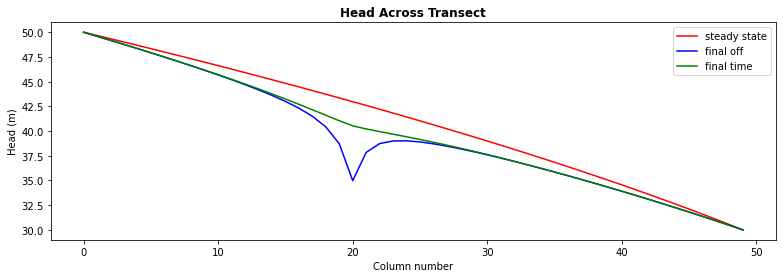

In [37]:

#plot head distribution at years 0, half of sim time, end of sim time
plt.plot(np.arange(nrow),headarray[0,20,:],'r',label='steady state')
plt.plot(np.arange(nrow),headarray[-2,20,:],'b',label='final off')
plt.plot(np.arange(nrow),headarray[-1,20,:],'g',label='final time')
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.title("Head Across Transect",fontweight='bold')
plt.legend()

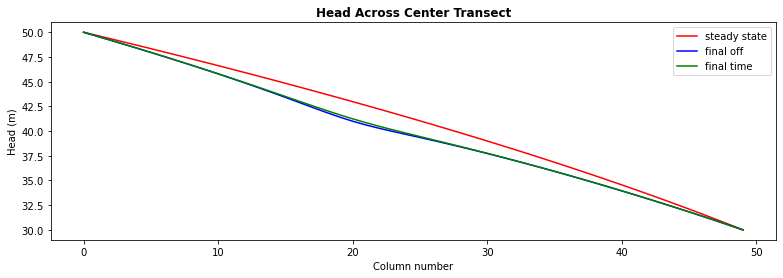

In [38]:
plt.plot(np.arange(nrow),headarray[0,25,:],'r',label='steady state')
plt.plot(np.arange(nrow),headarray[-2,25,:],'b',label='final off')
plt.plot(np.arange(nrow),headarray[-1,25,:],'g',label='final time')
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.title("Head Across Center Transect",fontweight='bold')
plt.legend()

In [39]:
'''#plot head distribution at years 0, half of sim time, end of sim time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:], levels=contour_levels) #create head contours   
tempfrf3 = frf[0,:,:].reshape(1,ncol,nrow)
tempfff3 = fff[0,:,:].reshape(1,ncol,nrow)
temphead3 = headarray[0,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf3, tempfff3, head=temphead3) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
plt.title('Head (m) at initial steady state', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

fig2 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[-1,:,:], levels=contour_levels) #create head contours   
tempfrf1 = frf[-1,:,:].reshape(1,ncol,nrow)
tempfff1 = fff[-1,:,:].reshape(1,ncol,nrow)
temphead1 = headarray[-1,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf1, tempfff1, head=temphead1) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
plt.title('Head (m) at end of simulation', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

fig3 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[2,:,:], levels=contour_levels) #create head contours   
tempfrf2 = frf[2,:,:].reshape(1,ncol,nrow)
tempfff2 = fff[2,:,:].reshape(1,ncol,nrow)
temphead2 = headarray[2,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf2, tempfff2, head=temphead2) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
plt.title('Head (m) at end of 23 years', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)'''

"#plot head distribution at years 0, half of sim time, end of sim time\nfig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure\nmodelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model\n# grid = modelmap.plot_grid() #plot model grid\nqm = modelmap.plot_ibound()  \ncontour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head\nhead_contours = modelmap.contour_array(headarray[0,:,:], levels=contour_levels) #create head contours   \ntempfrf3 = frf[0,:,:].reshape(1,ncol,nrow)\ntempfff3 = fff[0,:,:].reshape(1,ncol,nrow)\ntemphead3 = headarray[0,:,:].reshape(1,ncol,nrow)\nflows = modelmap.plot_discharge(tempfrf3, tempfff3, head=temphead3) #create discharge arrows\nplt.xlabel('Lx (m)',fontsize = 14)\nplt.ylabel('Ly (m)',fontsize = 14)\nplt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])\nplt.title('Head (m) at initial steady state', fontsize = 15, fontweight = 'bold')\nplt.colorbar(

### Plot drawdown

In [40]:
'''#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_min = np.min(headarray[0,:,:]-headarray[-1,:,:])
contour_max = np.max(headarray[0,:,:]-headarray[-1,:,:])
contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
#plt.gca().invert_yaxis()
plt.title('Drawdown (m) from steady state to final time', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_min = np.min(headarray[-2,:,:]-headarray[-1,:,:])
contour_max = np.max(headarray[-2,:,:]-headarray[-1,:,:])
contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[-2,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])
#plt.gca().invert_yaxis()
plt.title('Drawdown (m) from final off to final time', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)'''

"#plot change in head distribution between steady state and final time\nfig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure\nmodelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model\n# grid = modelmap.plot_grid() #plot model grid\nqm = modelmap.plot_ibound()  \ncontour_min = np.min(headarray[0,:,:]-headarray[-1,:,:])\ncontour_max = np.max(headarray[0,:,:]-headarray[-1,:,:])\ncontour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head\nhead_contours = modelmap.contour_array(headarray[0,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   \nplt.xlabel('Lx (m)',fontsize = 14)\nplt.ylabel('Ly (m)',fontsize = 14)\nplt.yticks([1, 100, 200, 300, 400,500], ['500', '400', '300','200','100','0'])\n#plt.gca().invert_yaxis()\nplt.title('Drawdown (m) from steady state to final time', fontsize = 15, fontweight = 'bold')\nplt.colorbar(head_contours,aspect=5)\n\n#plot change in head distribution between stead

In [53]:
cd = flopy.modpath.CellDataType()
print(cd)


In [54]:
fd = flopy.modpath.FaceDataType()

In [55]:
pg = flopy.modpath.LRCParticleData(lrcregions=time_series1)

TypeError: LRCParticleData: lrcregions should be a list of lists, tuples, or arrays not a <class 'numpy.ndarray'>.

In [56]:
pg = flopy.modpath.NodeParticleData(nodes=[100, 101])


In [57]:
#m = flopy.modflow.Modflow.load('C:\Users\Quilson2\OneDrive\Documents\SPRING21\582-GWMod\Course_Materials\Assignments\mf2005')
mp = flopy.modpath.Modpath7('mf2005_mp', flowmodel=m)
mpsim = flopy.modpath.Modpath7Sim(mp)